In [7]:
from IPython.display import YouTubeVideo
import cv2
import numpy as np
import os
import math
from matplotlib import pyplot as plt
from IPython.display import clear_output

%matplotlib inline
# Open a new thread to manage the external cv2 interaction
cv2.startWindowThread()

def plt_show(image, title=""):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.axis("off")
    plt.title(title)
    plt.imshow(image, cmap="Greys_r")
    plt.show()
    
class FaceDetector(object):
    def __init__(self, xml_path):
        self.classifier = cv2.CascadeClassifier(xml_path)
    
    def detect(self, image, biggest_only=True):
        scale_factor = 1.2
        min_neighbors = 5
        min_size = (30, 30)
        biggest_only = True
        flags = cv2.CASCADE_FIND_BIGGEST_OBJECT | \
                    cv2.CASCADE_DO_ROUGH_SEARCH if biggest_only else \
                    cv2.CASCADE_SCALE_IMAGE
        faces_coord = self.classifier.detectMultiScale(image,
                                                       scaleFactor=scale_factor,
                                                       minNeighbors=min_neighbors,
                                                       minSize=min_size,
                                                       flags=flags)
        return faces_coord
    
class VideoCamera(object):
    def __init__(self, index=0):
        self.video = cv2.VideoCapture(index)
        self.index = index
        print (self.video.isOpened())

    def __del__(self):
        self.video.release()
    
    def get_frame(self, in_grayscale=False):
        _, frame = self.video.read()
        if in_grayscale:
            #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        return frame

def cut_faces(image, faces_coord):
    faces = []
    
    for (x, y, w, h) in faces_coord:
        w_rm = int(0.3 * w / 2)
        faces.append(image[y: y + h, x + w_rm: x + w - w_rm])
         
    return faces

def normalize_intensity(images):
    images_norm = []
    for image in images:
        is_color = len(image.shape) == 3 
        if is_color:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        images_norm.append(cv2.equalizeHist(image))
    return images_norm

def resize(images, size=(50, 50)):
    images_norm = []
    for image in images:
        if image.shape < size:
            image_norm = cv2.resize(image, size, 
                                    interpolation=cv2.INTER_AREA)
        else:
            image_norm = cv2.resize(image, size, 
                                    interpolation=cv2.INTER_CUBIC)
        images_norm.append(image_norm)

    return images_norm

def normalize_faces(frame, faces_coord):
    faces = cut_faces(frame, faces_coord)
    faces = normalize_intensity(faces)
    faces = resize(faces)
    return faces

def draw_rectangle(image, coords):
    for (x, y, w, h) in coords:
        w_rm = int(0.2 * w / 2) 
        cv2.rectangle(image, (x + w_rm, y), (x + w - w_rm, y + h), 
                              (150, 150, 0), 8)

def collect_dataset():
    images = []
    labels = []
    labels_dic = {}
    people = [person for person in os.listdir("A:\people\/")]
    for i, person in enumerate(people):
        labels_dic[i] = person
        for image in os.listdir("A:\people\/" + person):
            images.append(cv2.imread("A:\people\/" + person + '/' + image, 0))
            labels.append(i)
    return (images, np.array(labels), labels_dic)

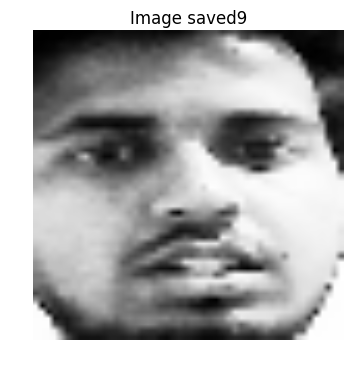

In [8]:
webcam = VideoCamera()
detector = FaceDetector('C:\/Users\/abhishek\Desktop\haarcascade_frontalface_default.xml')
#webcam = cv2.VideoCapture(0)
folder = "A:\people\/" + input('person:').lower() # input name
cv2.namedWindow("Python video",cv2.WINDOW_AUTOSIZE)
if not os.path.exists(folder):
    os.mkdir(folder)
    counter = 0
    timer = 0
    while counter < 10 : # take 20 photo
        frame = webcam.get_frame()
        face_coord = detector.detect(frame) # detected
        if len(face_coord) and timer % 700 == 50: # every second or so
            faces = normalize_faces(frame, face_coord) # norm pipeline
            cv2.imwrite(folder + '\/' + str(counter) + '.jpg', faces[0])
            plt_show(faces[0],"Image saved" + str(counter))
            clear_output(wait=True)
            counter+=1
        draw_rectangle(frame,face_coord)
        cv2.imshow("python", frame)
        cv2.waitKey(50)
        timer +=50
    cv2.destroyAllWindows()
else:

    print("name is already")
# Once this run , restart all steps but for next run skipp this section

In [9]:
images, labels, labels_dic = collect_dataset()

rec_eig = cv2.face.createEigenFaceRecognizer()
rec_eig.train(images, labels)

# needs at least two people 
rec_fisher = cv2.face.createFisherFaceRecognizer()
rec_fisher.train(images, labels)

rec_lbph = cv2.face.createLBPHFaceRecognizer()
rec_lbph.train(images, labels)

print ("Models Trained Succesfully")

Models Trained Succesfully


In [10]:
detector = FaceDetector("C:\/Users\/abhishek\Desktop\haarcascade_frontalface_default.xml")
webcam = VideoCamera(0)

True


In [11]:
cv2.namedWindow("PyData Tutorial", cv2.WINDOW_AUTOSIZE)
#detector = FaceDetector('C:\/Users\/abhishek\Desktop\haarcascade_frontalface_default.xml')
while True:
    frame = webcam.get_frame()
    faces_coord = detector.detect(frame, True) # detect more than one face
    if len(faces_coord):
        faces = normalize_faces(frame, faces_coord) # norm pipeline
        for i, face in enumerate(faces): # for each detected face
            collector = cv2.face.MinDistancePredictCollector()
            rec_lbph.predict(face, collector)
            conf = collector.getDist()
            pred = collector.getLabel()
            threshold = 140
            print ("Prediction: " + labels_dic[pred].capitalize() + "\nConfidence: " + str(round(conf)))
            cv2.putText(frame, labels_dic[pred].capitalize(),
                        (faces_coord[i][0], faces_coord[i][1] - 10),
                        cv2.FONT_HERSHEY_PLAIN, 3, (66, 53, 243), 2)
        clear_output(wait = True)
        draw_rectangle(frame, faces_coord) # rectangle around face
    cv2.putText(frame, "ESC to exit", (5, frame.shape[0] - 5),
                    cv2.FONT_HERSHEY_PLAIN, 1.3, (66, 53, 243), 2, cv2.LINE_AA)
    cv2.imshow("PyData Tutorial", frame) # live feed in external
    if cv2.waitKey(40) & 0xFF == 27:
        cv2.destroyAllWindows()
        break

AttributeError: 'NoneType' object has no attribute 'shape'

In [5]:
cv2.namedWindow("PyData Tutorial", cv2.WINDOW_AUTOSIZE)
while True:
    frame = webcam.get_frame()
    faces_coord = detector.detect(frame, False) # detect more than one face
    if len(faces_coord):
        faces = normalize_faces(frame, faces_coord) # norm pipeline
        for i, face in enumerate(faces): # for each detected face
            collector = cv2.face.MinDistancePredictCollector()
            rec_lbph.predict(face, collector)
            conf = collector.getDist()
            pred = collector.getLabel()
            threshold = 140
            print ("Prediction: " + labels_dic[pred].capitalize() + "\nConfidence: " + str(round(conf)))
            clear_output(wait = True)
            if conf < threshold: # apply threshold
                cv2.putText(frame, labels_dic[pred].capitalize(),
                            (faces_coord[i][0], faces_coord[i][1] - 10),
                            cv2.FONT_HERSHEY_PLAIN, 3, (66, 53, 243), 2)
            else:
                cv2.putText(frame, "Unknown",
                            (faces_coord[i][0], faces_coord[i][1]),
                            cv2.FONT_HERSHEY_PLAIN, 3, (66, 53, 243), 2)
        draw_rectangle(frame, faces_coord) # rectangle around face
    cv2.putText(frame, "ESC to exit", (5, frame.shape[0] - 5),
                    cv2.FONT_HERSHEY_PLAIN, 1.3, (66, 53, 243), 2, cv2.LINE_AA)
    cv2.imshow("PyData Tutorial", frame) # live feed in external
    if cv2.waitKey(40) & 0xFF == 27:
        cv2.destroyAllWindows()
        break

Prediction: Abhishek
Confidence: 139


In [6]:
del webcam